In [1]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
sys.path.insert(0, os.path.abspath('../'))
from src.lib import centroids as centutils
plt.rcParams['figure.figsize'] = [15, 15]

########## Iteration 0 ########## 
N centroids: 115
N centroids after removing centroids in white space: 107
N centroids after removing close points: 105
N centroids after Delaunay analysis: 102
########## Iteration 1 ########## 
N centroids: 102
N centroids after removing centroids in white space: 102
N centroids after removing close points: 102
N centroids after Delaunay analysis: 102
########## Iteration 2 ########## 
N centroids: 102
N centroids after removing centroids in white space: 102
N centroids after removing close points: 102
N centroids after Delaunay analysis: 102


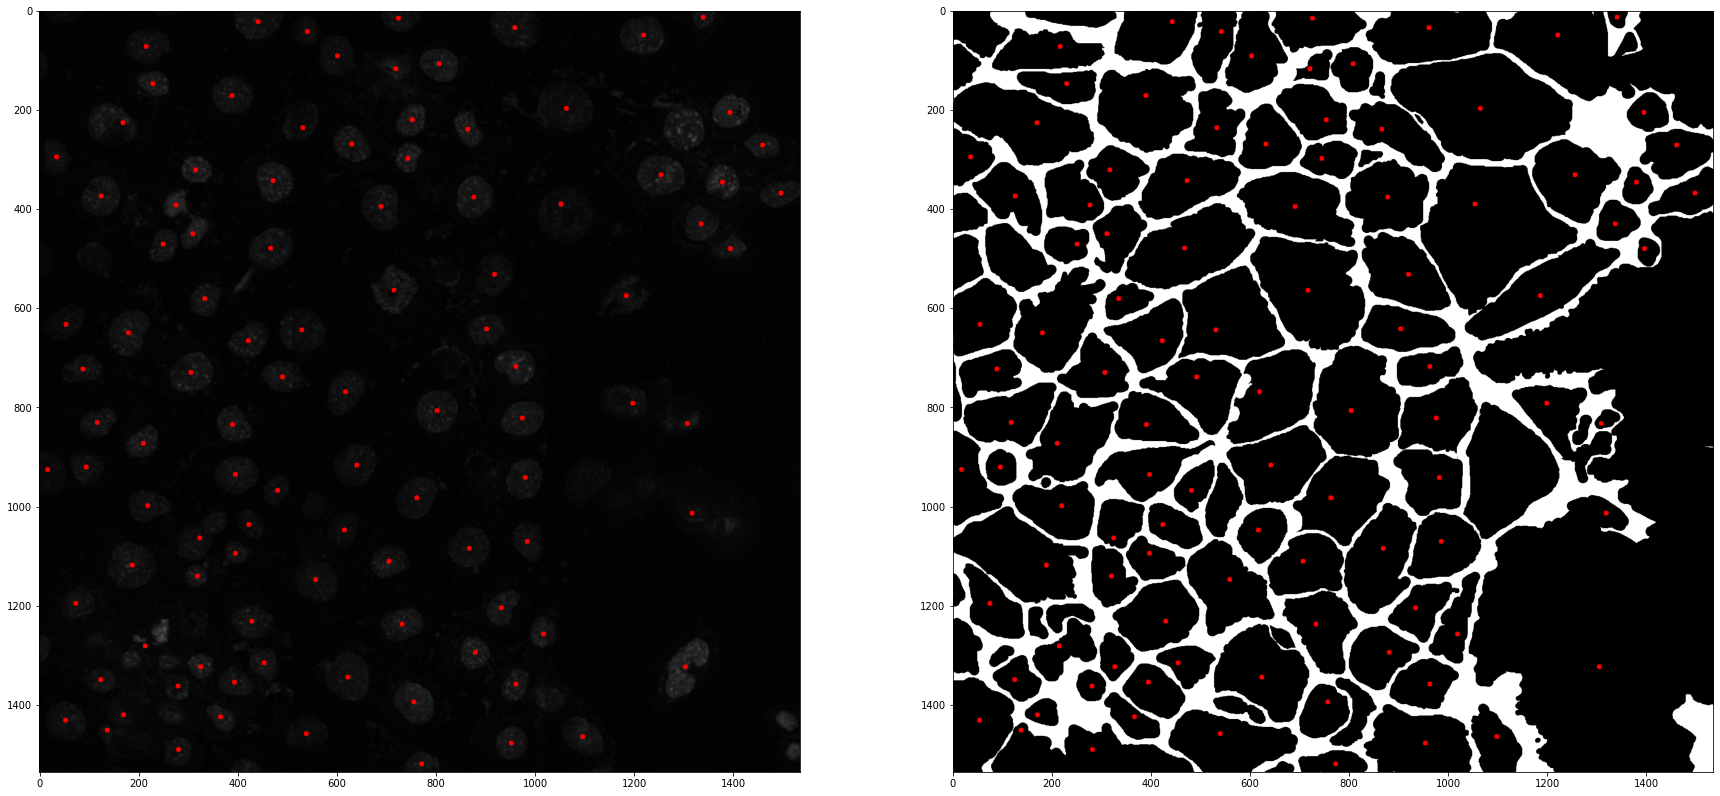

In [2]:
nuclei_path = '../data/AKT1_B1_CAn.tif'
jbin_path = '../data/AKT1_B1_CAj-BI.tif'
jsk_path = '../data/AKT1_B1_CAj-SK.tif'
j_path = '../data/AKT1_B1_CAj.tif'

nuclei_img = cv2.imread(nuclei_path)
jbin_img = cv2.imread(jbin_path)
jsk_img = cv2.imread(jsk_path)
j_img = cv2.imread(j_path)

centroids = centutils.get_nuclei_centroids(nuclei_img)
cleaned_centroids = centutils.clean_centroids(centroids, jbin_img)

nuclei_centroids_img = centutils.draw_centroids(cleaned_centroids, nuclei_img)
jbin_centroids_img = centutils.draw_centroids(cleaned_centroids, jbin_img)

fig, ax = plt.subplots(1, 2, figsize=(30, 15))
ax[0].imshow(nuclei_centroids_img)
ax[1].imshow(jbin_centroids_img)

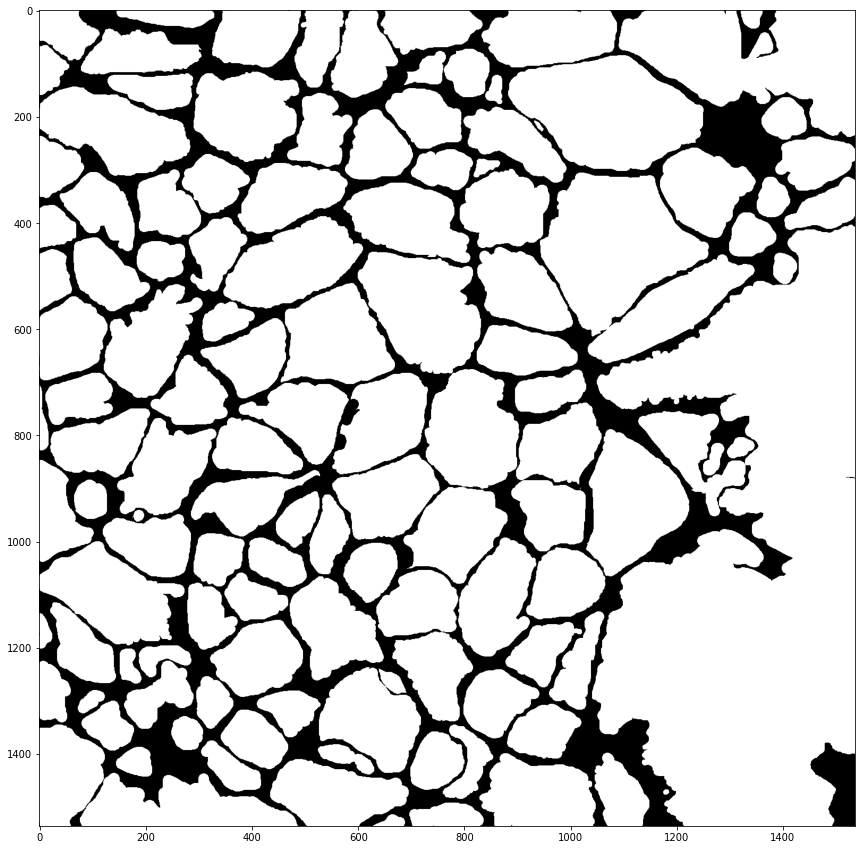

In [10]:
inv_jbin_img = cv2.bitwise_not(jbin_img)
inv_jbin_img = cv2.cvtColor(inv_jbin_img, cv2.COLOR_BGR2GRAY)
plt.imshow(inv_jbin_img, cmap='gray')

In [97]:
contours, hierarchy = cv2.findContours(inv_jbin_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

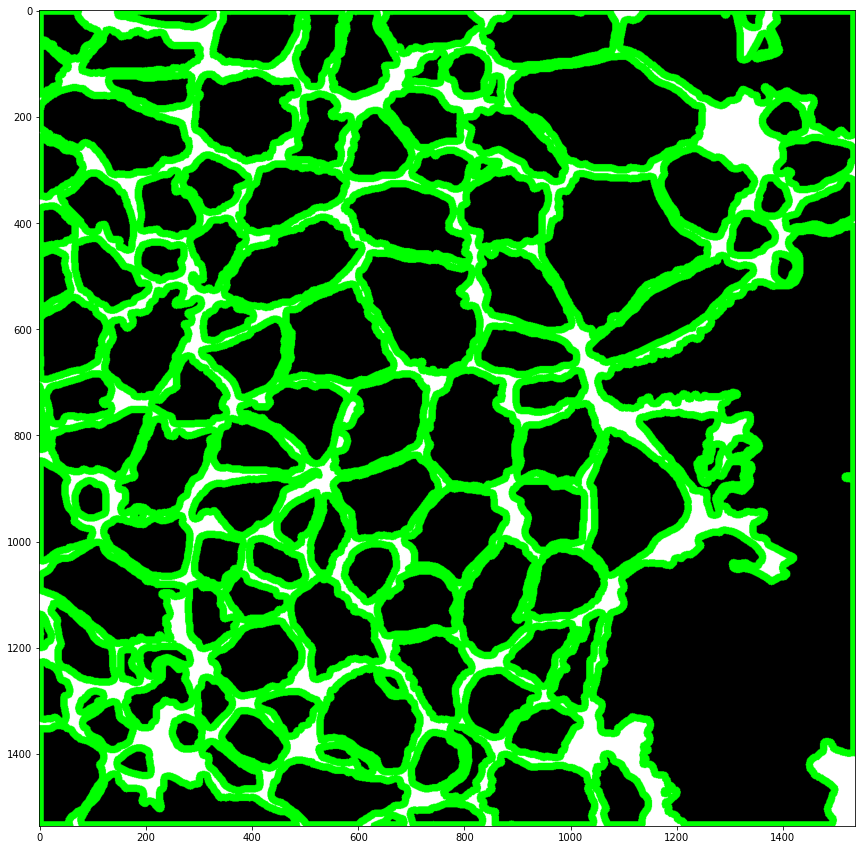

In [98]:
x = cv2.drawContours(jbin_img, contours, -1, (0,255,0), 3)
plt.imshow(x)

In [99]:
def get_moments(contours):
    moments = []
    for c in contours:
        m = cv2.moments(c)
        moments.append(m)
    return moments

In [100]:
def get_colored_contours(contours, img_template):
    colors = np.random.randint(0, 256, (len(contours), 3)).astype('uint8')
    colors_dict = {tuple(colors[index]): index for index in range(len(colors))}

    contours_color = np.zeros_like(img_template)
    for contour, color in zip(contours, colors):
        color_t = tuple(int(c) for c in color)
        cv2.fillPoly(contours_color, [contour], color=color_t)
    return contours_color, colors_dict

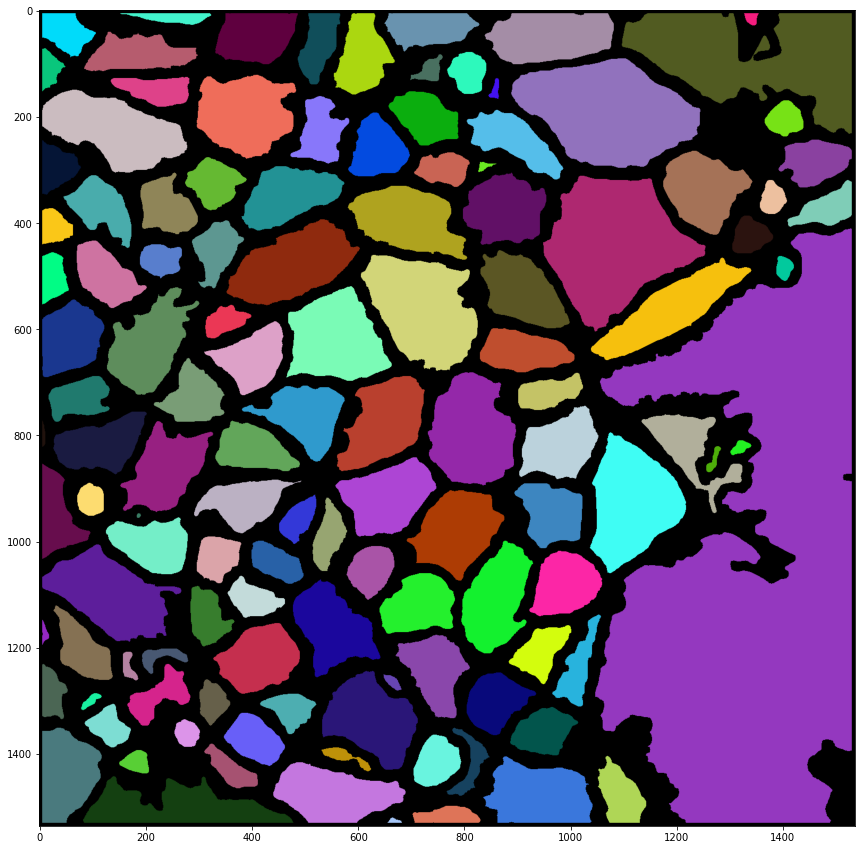

In [102]:
colored, c_dict = get_colored_contours(contours, jbin_img)
plt.imshow(colored)

In [123]:
def get_moments_centroids(centroids, contours, img_template):
    moments = get_moments(contours)
    ret = []
    colored_img, colors_dict = get_colored_contours(contours, img_template)
    for centroid in centroids:
        color = tuple(colored_img[centroid[1], centroid[0]])
        index = colors_dict[color]
        ret.append(moments[index])
    return ret

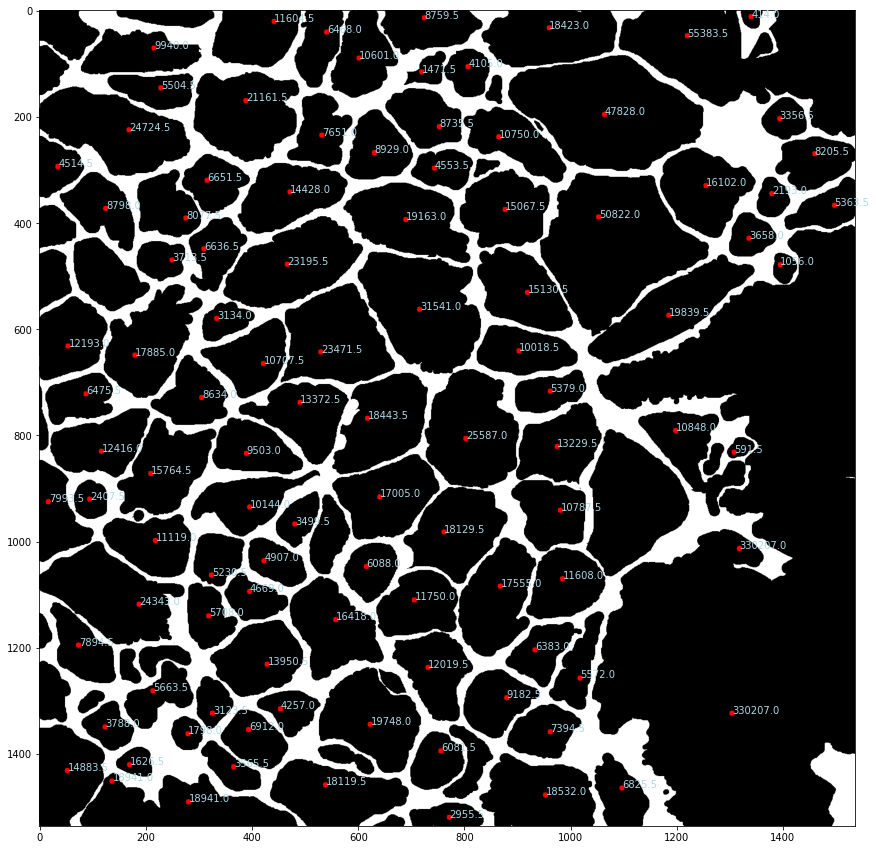

In [124]:
fig, ax = plt.subplots(1)
ax.imshow(jbin_centroids_img)
moments = get_moments_centroids(cleaned_centroids, contours, jbin_img)

for centroid, moment in zip(cleaned_centroids, moments):
    area = moment['m00']
    ax.text(centroid[0], centroid[1], str(area), color='lightblue')

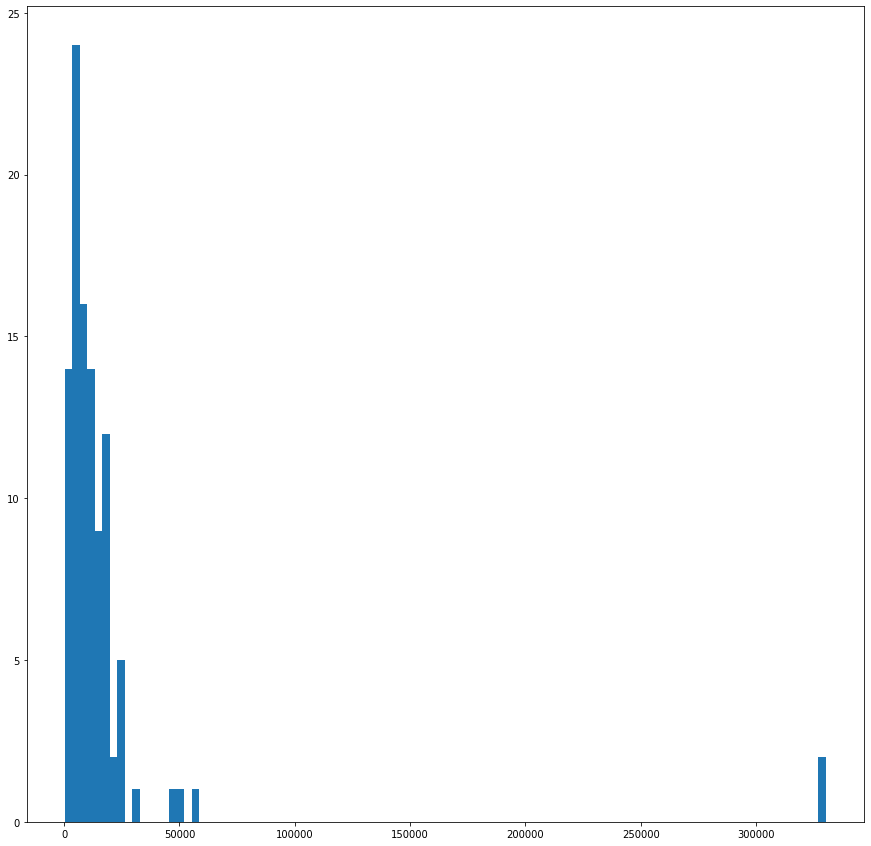

In [129]:
areas = np.array([m['m00'] for m in moments])
n, bins, patches = plt.hist(areas, bins=len(areas))
plt.show()

In [130]:
mean = areas.mean()
std = areas.std()
mean, std

(17844.196078431374, 45182.51719215516)

In [133]:
len(centroids), len(areas)

(115, 102)

In [138]:
for i in range(len(cleaned_centroids)):
    area = areas[i]
    centroid = centroids[i]
    if abs(area - mean) > 2*std:
        print(centroid, area)

[1030 1387] 330207.0
[1064  196] 330207.0


In [147]:
def remove_outliers_cells(centroids, moments):
    moments_np = np.array(moments)
    areas = np.array([m['m00'] for m in moments])
    mask = np.ones(len(centroids), dtype=bool)
    mean, std = areas.mean(), areas.std()
    for index, (centroid, area) in enumerate(zip(centroids, areas)):
        if abs(area - mean) > 2*std:
            mask[index] = False
    return centroids[mask], moments_np[mask]

def get_moments_cells(centroids, bin_img, remove_outliers=True):
    inv_img = cv2.bitwise_not(bin_img)
    inv_img = cv2.cvtColor(inv_img, cv2.COLOR_BGR2GRAY)
    contours, hierarchy = cv2.findContours(inv_jbin_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    moments = get_moments_centroids(centroids, contours, bin_img)
    if remove_outliers:
        return remove_outliers_cells(centroids, moments)
    else:
        return centroids, moments

In [148]:
nuclei_img = cv2.imread(nuclei_path)
jbin_img = cv2.imread(jbin_path)

centroids = centutils.get_nuclei_centroids(nuclei_img)
centroids = centutils.clean_centroids(centroids, jbin_img)

nuclei_centroids_img = centutils.draw_centroids(centroids, nuclei_img)
jbin_centroids_img = centutils.draw_centroids(centroids, jbin_img)

centroids, moments = get_moments_cells(centroids, jbin_img)

########## Iteration 0 ########## 
N centroids: 115
N centroids after removing centroids in white space: 107
N centroids after removing close points: 105
N centroids after Delaunay analysis: 102
########## Iteration 1 ########## 
N centroids: 102
N centroids after removing centroids in white space: 102
N centroids after removing close points: 102
N centroids after Delaunay analysis: 102
########## Iteration 2 ########## 
N centroids: 102
N centroids after removing centroids in white space: 102
N centroids after removing close points: 102
N centroids after Delaunay analysis: 102


In [150]:
len(centroids), len(moments)

(100, 100)

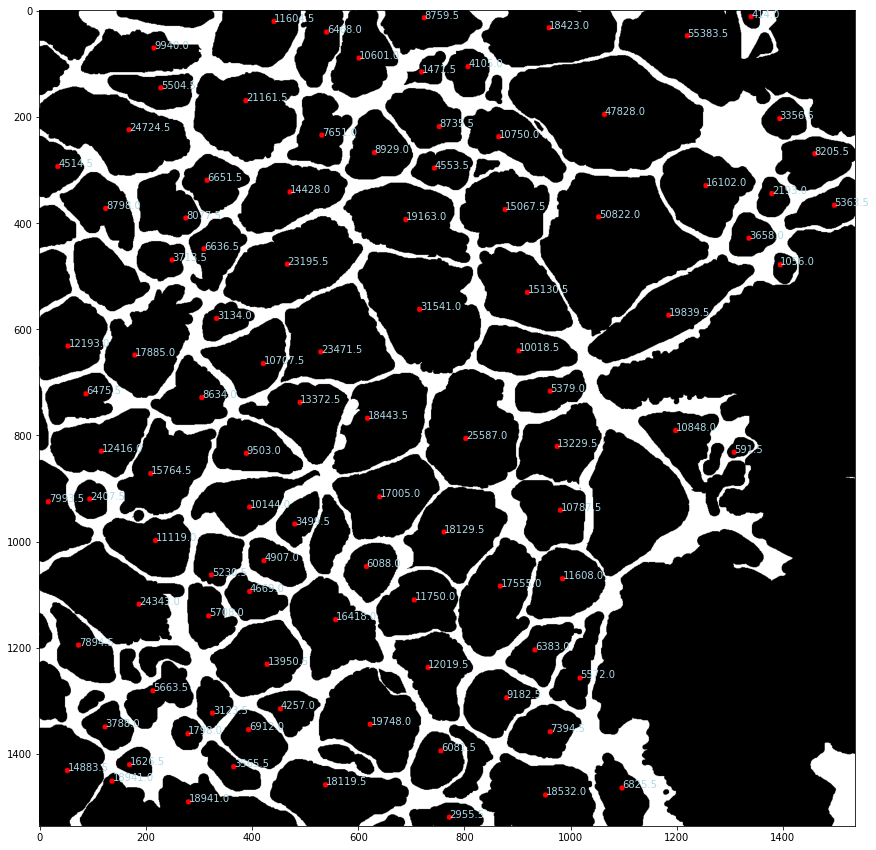

In [152]:
bin_centroid_final = centutils.draw_centroids(centroids, jbin_img)

fig, ax = plt.subplots(1)
ax.imshow(bin_centroid_final)

for centroid, moment in zip(centroids, moments):
    area = moment['m00']
    ax.text(centroid[0], centroid[1], str(area), color='lightblue')